In [13]:
import pandas as pd
import numpy as np
import pickle
from src.preprocessing.utils_preprocessing import PreProcessingPipe
import matplotlib.pyplot as plt
import matplotlib as mpl 

mpl.rcParams["figure.dpi"] = 200

Let's build the FAR and FRR and analyze the best threshold to use for this model

# FAR

We need the test dataset when those values are Fraud.

In [ ]:
# data
fraud_df = pd.read_csv("data/second-eda-output.csv")
fraud_df["day_of_month"] = fraud_df["day_of_month"].astype(str)

# Pre-processing Pipeline
pre_processing_pipe = PreProcessingPipe(dataset=fraud_df)
pre_processing_pipe.train_test_splitting(
    sample_test_size=0.40, to_drop=["is_fraud"]
)
pre_processing_pipe.one_hot_encoder(["day_of_month", "type"])

# x_test and y_test
x_test = pre_processing_pipe.X_test
y_test = pre_processing_pipe.y_test

# sample with 100 observations
fraud_transformed_data = pd.concat([x_test, y_test], axis=1)
not_fraud_100 = fraud_transformed_data[fraud_transformed_data["is_fraud"] == 0].sample(100).drop(['is_fraud'], axis=1)

In [ ]:
# model
model_path = ["models/21_01_22_lr_w_v2.sav", "models/21_01_22_lr_w_v3.sav", "models/21_01_22_lr_w_v1.sav", "models/19_01_22_lr_w_v1.sav", "models/lrc_baseline.sav"]

for model in model_path[:1]:
    with open(model, "rb") as f:
            model = pickle.load(f)

    # far
    y_hat_class = model.predict(not_fraud_100)
    y_hat_prob = model.predict_proba(not_fraud_100)
    probs = list(y_hat_prob[:, 1]*100)
    probs_int = [int(prob) for prob in probs]

    probs_real_int = []
    for i, yhat in enumerate(yhat_class):
        if not_fraud_w_hat["is_fraud"].values[i] != yhat:
            probs_real_int.append(probs_int[i])

    # apply the threshold and save how many observations passes
    far = []
    threshold = []
    for i in range(100):
        num = 0
        for value in probs_int:
            if value > i:
                num += 1
        far.append(num)
        threshold.append(i)

    far = np.array(far)

    # frr
    fraud_100_w_hat = fraud_transformed_data[
        fraud_transformed_data["is_fraud"] == 1
    ].sample(100)
    fraud_100 = fraud_100_w_hat.drop(["is_fraud"], axis=1)

    yhat_class = model.predict(fraud_100)
    print(yhat_class)
    yhat_prob = model.predict_proba(fraud_100)
    probs = list(yhat_prob[:, 0] * 100)
    probs_int = [int(prob) for prob in probs]

    probs_real_int = []
    for i, yhat in enumerate(yhat_class):
        if fraud_100_w_hat["is_fraud"].values[i] != yhat:
            probs_real_int.append(probs_int[i])

    frr = []
    for i in range(100):
        num = 0

        for x in probs_real_int:
            if x < i:
                num += 1
        # print(i,num)
        frr.append(num)


    frr = np.array(frr)


    plt.plot(threshold, frr, '--b')
    plt.xlabel('threshold')
    plt.title('FRR')
    plt.axis([0, 100, 0, 100])
    plt.show()

    plt.plot(threshold,far,'--r')
    plt.xlabel('threshold')
    plt.title('FAR')

    plt.axis([5, 20, 0, 100])
    plt.show()
    fig, ax = plt.subplots()

    ax.plot(threshold, far, 'r--', label='FAR')
    ax.plot(threshold, frr, 'g--', label='FRR')
    plt.xlabel('Threshold')
    plt.axvline(x=50, ymin=0, ymax=40)

    legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

    # Put a nicer background color on the legend.
    legend.get_frame().set_facecolor('C0')

    plt.show()



In [30]:
y_test["is_fraud"].values

array([0, 0, 0, ..., 0, 0, 0])

RandomForestClassifier(n_jobs=-1)


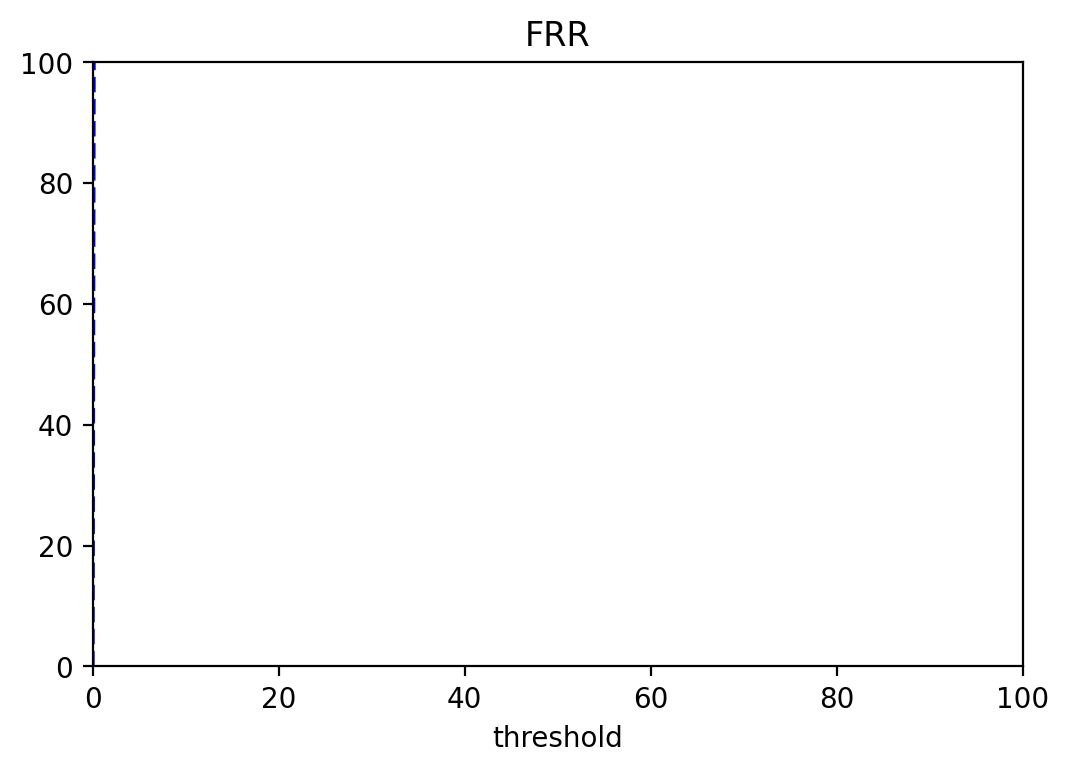

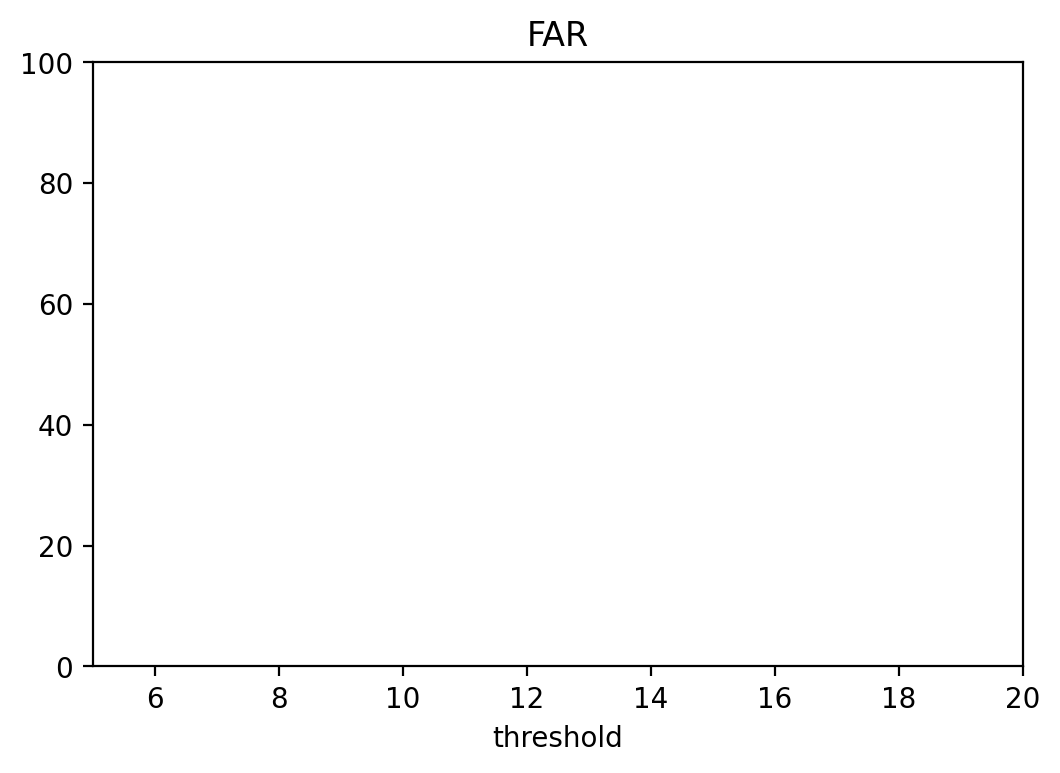

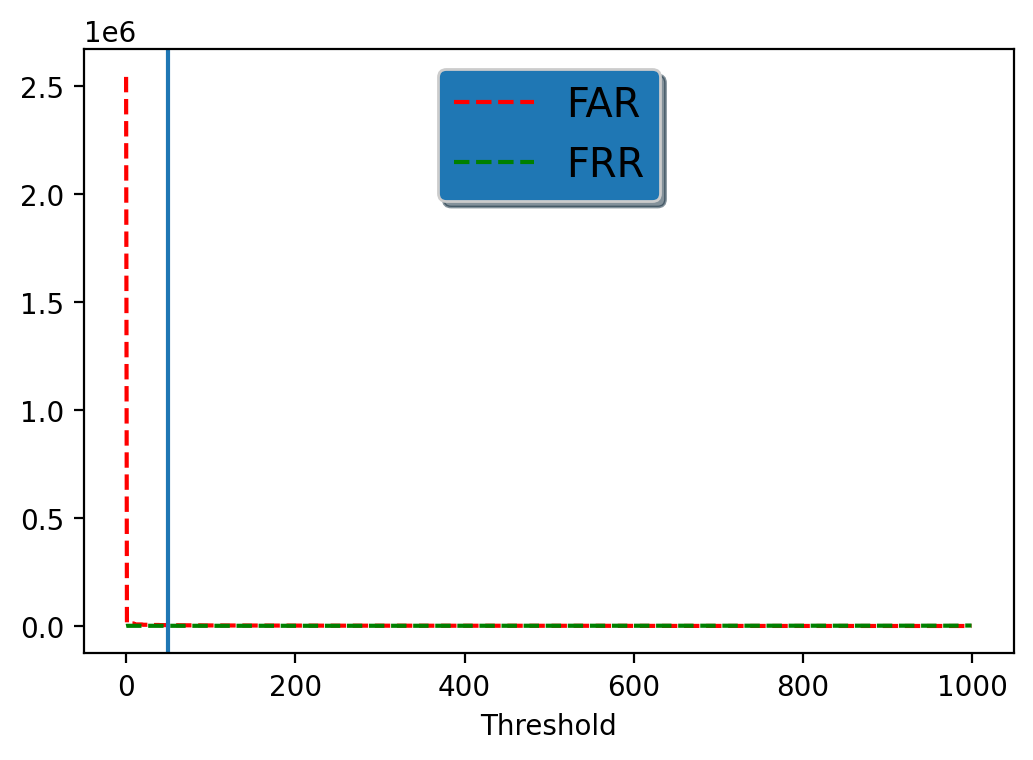

In [76]:
# model
model_path = ["models/21_01_22_lr_w_v3.sav", "models/21_01_22_lr_w_v1.sav", "models/19_01_22_lr_v1.sav"]

for model in model_path[:1]:
    with open(model, "rb") as f:
            model = pickle.load(f)
            print(model)
    # far
    y_hat_class = model.predict(x_test)
    y_hat_prob = model.predict_proba(x_test)

    threshold, frr, far = calculate_far_frr(y_proba=y_hat_prob[:, 1], y_true=y_test["is_fraud"])

    threshold = list(range(0, 1000))

    plt.plot(threshold, frr, '--b')
    plt.xlabel('threshold')
    plt.title('FRR')
    plt.axis([0, 100, 0, 100])
    plt.show()    

    plt.plot(threshold,far,'--r')
    plt.xlabel('threshold')
    plt.title('FAR')    
    plt.axis([5, 20, 0, 100])
    plt.show()
    
    fig, ax = plt.subplots()    
    ax.plot(threshold, far, 'r--', label='FAR')
    ax.plot(threshold, frr, 'g--', label='FRR')
    plt.xlabel('Threshold')
    plt.axvline(x=50, ymin=0, ymax=40)    
    legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')    
    # Put a nicer background color on the legend.
    legend.get_frame().set_facecolor('C0')    
    plt.show()


ValueError: x, y, and format string must not be None

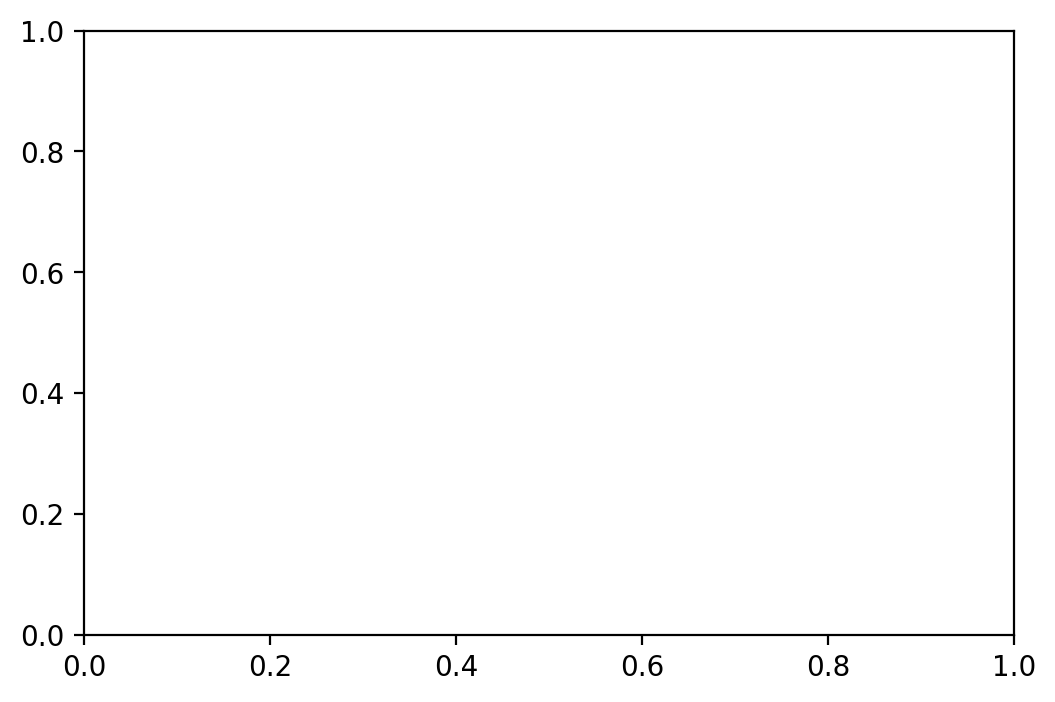

In [40]:
plt.plot(threshold, frr, '--b')
plt.xlabel('threshold')
plt.title('FRR')
plt.axis([0, 100, 0, 100])
plt.show()

plt.plot(threshold,far,'--r')
plt.xlabel('threshold')
plt.title('FAR')

plt.axis([5, 20, 0, 100])
plt.show()
fig, ax = plt.subplots()

ax.plot(threshold, far, 'r--', label='FAR')
ax.plot(threshold, frr, 'g--', label='FRR')
plt.xlabel('Threshold')
plt.axvline(x=50, ymin=0, ymax=40)

legend = ax.legend(loc='upper center', shadow=True, fontsize='x-large')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [69]:
def calculate_far_frr(y_proba, y_true, n_points=1000, normalize=False, threshold=None):
    thr = np.linspace(0, 1, n_points)
    far = []
    frr = []
    for t in thr:
        far_pt = y_proba[y_true == 0] >= t
        frr_pt = y_proba[y_true == 1] < t
        if normalize:
            far.append(far_pt.mean())
            frr.append(frr_pt.mean())
        else:
            far.append(far_pt.sum())
            frr.append(frr_pt.sum())

    if threshold is None:
        far = np.array(far)
        frr = np.array(frr)
        optm = thr[abs(far - frr).argmin()]
    else:
        optm = threshold

    return threshold, frr, far


In [63]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(probas_pred=y_hat_prob[:, 1], y_true=y_test["is_fraud"].values)

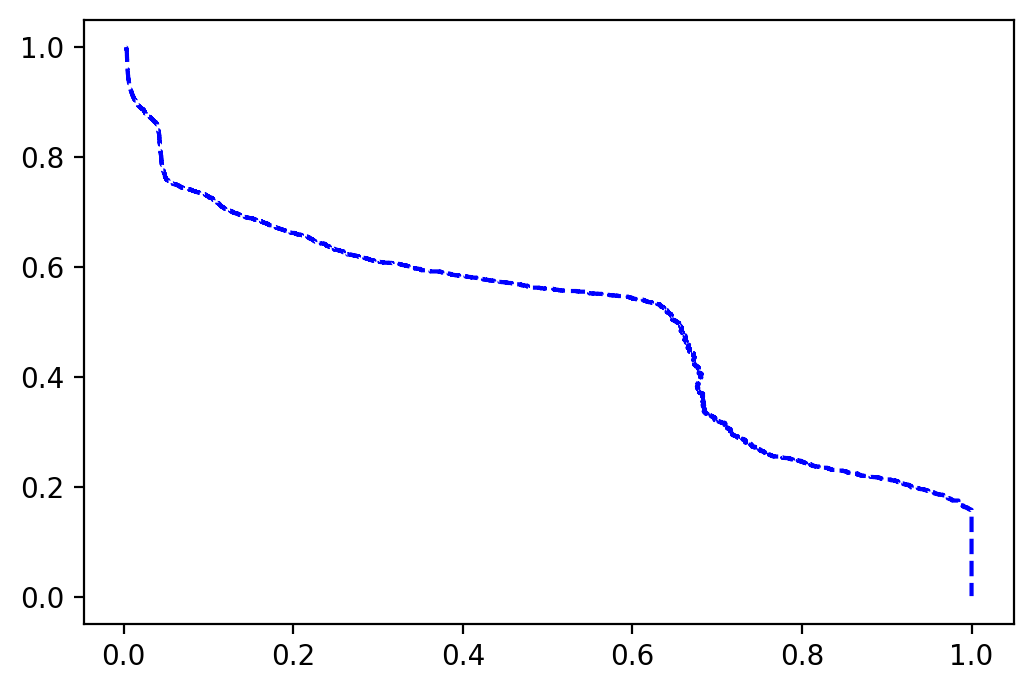

In [72]:
plt.plot(precisions[:-1], recalls[:-1], 'b--', label="precision")
plt.show()
